# Tuning query parameters for the MSMARCO Document dataset

The following shows a principled, data-driven approach to tuning parameters of a basic query, such as field boosts, using the MSMARCO Document dataset.

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import importlib
import os
import sys

from elasticsearch import Elasticsearch
from skopt.plots import plot_objective

In [7]:
# project library
sys.path.insert(0, os.path.abspath('..'))

import qopt
importlib.reload(qopt)

from qopt.notebooks import evaluate_mrr100_dev, optimize_query_mrr100
from qopt.optimize import Config

In [8]:
# use a local Elasticsearch or Cloud instance (https://cloud.elastic.co/)
# es = Elasticsearch('http://localhost:9200')
es = Elasticsearch('http://35.234.93.126:9200')

# set the parallelization parameter `max_concurrent_searches` for the Rank Evaluation API calls
# max_concurrent_searches = 10
max_concurrent_searches = 30

index = 'msmarco-document'
template_id = 'cross_fields'

## Baseline evaluation

Let's look at a basic query that might be used to search documents that have multuple fields. This query uses [the `multi_match` query of type `cross_fields`](https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-multi-match-query.html#type-cross-fields) to search for query terms across the `url`, `title`, and `body` fields. Here's what the search template looks like that we'll be using:

```json
{
    "query": {
      "multi_match": {
        "type": "cross_fields",
        "query": "{{query_string}}",
        "operator": "{{operator}}",
        "minimum_should_match": "{{minimum_should_match}}%",
        "tie_breaker": "{{tie_breaker}}",
        "fields": [
          "url^{{url|boost}}",
          "title^{{title|boost}}",
          "body^{{body|boost}}"
        ]
      }
    }
}
```

First we'll run an evaluation on the "development" (or `dev` in MSMARCO terms) dataset using the standardized metric for MSMARCO, MRR@100. This will show us what our baseline is that we want to improve against. We'll use default values for all parameters in the template above.

In [5]:
%%time

_ = evaluate_mrr100_dev(es, max_concurrent_searches, index, template_id,
    params={
        'operator': 'OR',
        'minimum_should_match': 50,  # in percent/%
        'tie_breaker': 0.0,
        'url|boost': 1.0,
        'title|boost': 1.0,
        'body|boost': 1.0,
    })

Evaluation with: MRR@100
Score: 0.2683
CPU times: user 2.62 s, sys: 1.43 s, total: 4.06 s
Wall time: 1min 37s


Now we have a baseline score that we'll iterate towards improving.

## Getting started with tuning: low dimensionality and discrete parameter values

There's a lot of parameters that we need to choose for this query. There's three boost parameters (one for each field) and then the `operator`, `minimum_should_match`, and `tie_breaker` parameters. We're going to break this up into steps and optimize using basic approaches first. Breaking things up like this allows us to tackle the problem in steps and avoids introducing a large amount of complexity and what is called a large parameter space. A parameter space is the total scope of all parameters combined, and all possible values of those parameters. If we have 3 parameters, we have a 3 _dimensional_ space and each possible combination of parameters is what makes up the coordinates of that space.

Let's start with just using all the default values but looking at the difference between the `operator` values `['OR', 'AND']` in combination with a few optoins for `minimum_should_match`, since these parameters sometimes have an effect together. Since we have just two dimensions and a few possible values each, the parameter space is very small. In this case it's `operator:2 * minimum_should_match:5 = 10`. That's pretty small and so we'll use a simple grid search that will test every possible combination of those parmeters, 10 tests in all.

When we do this search over the parameters space, we'll use a different dataset to avoid overfitting (coming up with parameter values that work only on one dataset) and then do another evaluation on the dev dataset (as above) after finding what we think are the optimal parameter values in order to check our results. To make this process a bit faster (although less robust), we'll continue to use MRR@100 but with a training query dataset of just 1,000 queries compared to the over 3,000 in the development dataset.

In [8]:
%%time

_ = optimize_query_mrr100(es, max_concurrent_searches, index, template_id,
    config_space=Config.parse({
        'method': 'grid',
        'space': {
            'operator': ['OR', 'AND'],
            'minimum_should_match': [30, 40, 50, 60, 70],
        },
        'default': {
            'tie_breaker': 0.0,
            'url|boost': 1.0,
            'title|boost': 1.0,
            'body|boost': 1.0,
        }
    }))

Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
 - iteration 1 scored 0.2282 with: {'operator': 'OR', 'minimum_should_match': 30}
 - iteration 2 scored 0.1999 with: {'operator': 'AND', 'minimum_should_match': 30}
 - iteration 3 scored 0.2282 with: {'operator': 'OR', 'minimum_should_match': 40}
 - iteration 4 scored 0.1999 with: {'operator': 'AND', 'minimum_should_match': 40}
 - iteration 5 scored 0.2280 with: {'operator': 'OR', 'minimum_should_match': 50}
 - iteration 6 scored 0.1999 with: {'operator': 'AND', 'minimum_should_match': 50}
 - iteration 7 scored 0.2279 with: {'operator': 'OR', 'minimum_should_match': 60}
 - iteration 8 scored 0.1999 with: {'operator': 'AND', 'minimum_should_match': 60}
 - iteration 9 scored 0.2280 with: {'operator': 'OR', 'minimum_should_match': 70}
 - iteration 10 scored 0.1999 with: {'operator': 'AND', 'minimum_should_match': 70}
Best score: 0

The first thing we notice is that there's really not much difference between the variants of `minimum_should_match`. There is however a very big difference between `OR` and `AND` `operator`. It's pretty clear that with the kinds of queries we get in this dataset (long-form, natural language questions), that `OR` is always better than `AND`. Based on this we're going to just assume that `OR` is always the better option and we'll continue to look for a good `minimum_should_match`. Let's do that in combination with `tie_breaker` now since those two parameters can have an impact on each other. We'll start simple again with a grid search over a limited number of parameter values for each, all of which are discrete values. With two dimensions and five parameter values each, we have a parameter space of size 25 and can test every possible value in a reasonable amount of time.

In [10]:
%%time

_, _, final_params_msmtb, _ = optimize_query_mrr100(es, max_concurrent_searches, index, template_id,
    config_space=Config.parse({
        'method': 'grid',
        'space': {
            'minimum_should_match': [30, 40, 50, 60, 70],
            'tie_breaker': [0.0, 0.25, 0.5, 0.75, 1.0],
        },
        'default': {
            'operator': 'OR',
            'url|boost': 1.0,
            'title|boost': 1.0,
            'body|boost': 1.0,
        }
    }))

Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
 - iteration 1 scored 0.2282 with: {'minimum_should_match': 30, 'tie_breaker': 0.0}
 - iteration 2 scored 0.2514 with: {'minimum_should_match': 30, 'tie_breaker': 0.25}
 - iteration 3 scored 0.2425 with: {'minimum_should_match': 30, 'tie_breaker': 0.5}
 - iteration 4 scored 0.2286 with: {'minimum_should_match': 30, 'tie_breaker': 0.75}
 - iteration 5 scored 0.2178 with: {'minimum_should_match': 30, 'tie_breaker': 1.0}
 - iteration 6 scored 0.2282 with: {'minimum_should_match': 40, 'tie_breaker': 0.0}
 - iteration 7 scored 0.2532 with: {'minimum_should_match': 40, 'tie_breaker': 0.25}
 - iteration 8 scored 0.2436 with: {'minimum_should_match': 40, 'tie_breaker': 0.5}
 - iteration 9 scored 0.2292 with: {'minimum_should_match': 40, 'tie_breaker': 0.75}
 - iteration 10 scored 0.2184 with: {'minimum_should_match': 40, 'tie_breaker':

Well that looks pretty good and we see some improvements on the training set. Let's evaluate on the development dataset now using the best parameters we've found so far. This will show us where we are relative to the baseline query.

In [11]:
%%time

_ = evaluate_mrr100_dev(es, max_concurrent_searches, index, template_id, params=final_params_msmtb)

Evaluation with: MRR@100
Score: 0.2841
CPU times: user 2.18 s, sys: 942 ms, total: 3.12 s
Wall time: 1min 33s


Definitely a good improvement and all we've done is optimize a few basic query parameters!

## Advanced tuning: high dimensionality and continuous parameter values

So the question now is, can we improve this query further by tuning each of the field boosts? One of the difficulties with picking field boosts intuitively is that they are not necesarrily interpretable in relation to each other. That is, a weight of `2.0` on the `title` field does not mean that it is two times more important than the `body` field with a boost of `1.0`. In order to find the best field boosts, we'll need to search over a parameter space that includes a continuous range from `0.0` to `10.0`.

We can't just use a grid search as we did above, testing each possible combination of the three field boosts, as an exhaustive search would require 1,000 evaluations if we test just at steps of `1` and no finer (10 steps per parameter, 3 parameters, makes `10 * 10 * 10` evaluations). Since the evaluation method is time consuming and a grid search over all combinations would be prohibitive, we'll use [Bayesian optimization](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f) to pick the combinations of boosts. We're going to use a lot of iterations and probably more than necessary, but it'll be useful in a later step to plot the parameter space. Note that there are two iteration parameters that we need to set. First the `num_iterations` which controls the total numnber of iterations in the process. Second the `num_initial_points` is used to control the number of iterations that will randomly select parameter values from the parameter space, which are used to seed the Bayesian optimization process. That means the number of iterations that actually use Bayesian optimization (prior results used to select the next parameter values to try) is in fact `num_iterations - num_initial_points`. It's important to not set the `num_initial_points` too low or your Bayesian process may find the best parameters much more slowly (i.e. need more total `num_iterations`).

Since we already found the optimal `operator`, `minimum_should_match` and `tie_breaker` parameters in the steps above, we'll bring those forward as default parameters that don't need to optimized any further. The current best parameters are as follows.

In [12]:
final_params_msmtb

{'operator': 'OR',
 'url|boost': 1.0,
 'title|boost': 1.0,
 'body|boost': 1.0,
 'minimum_should_match': 50,
 'tie_breaker': 0.25}

In [13]:
%%time

_, _, final_params_boosts, metadata_boosts = optimize_query_mrr100(es, max_concurrent_searches, index, template_id,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 50,
        'num_initial_points': 20,
        'space': {
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
        },
        'default': final_params_msmtb,
    }))

Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
 - iteration 1 scored 0.1587 with: {'url|boost': 8.726985471807735, 'title|boost': 4.9640027399534725, 'body|boost': 0.11609056216554726}
 - iteration 2 scored 0.1762 with: {'url|boost': 6.916676411541236, 'title|boost': 8.095424520867578, 'body|boost': 1.0712666098791892}
 - iteration 3 scored 0.2549 with: {'url|boost': 3.007796608892666, 'title|boost': 5.339403697417464, 'body|boost': 7.966190518725855}
 - iteration 4 scored 0.1596 with: {'url|boost': 8.638276792021543, 'title|boost': 0.06545586866499532, 'body|boost': 1.2778376386896975}
 - iteration 5 scored 0.2502 with: {'url|boost': 4.221914106579623, 'title|boost': 2.4722338205569976, 'body|boost': 6.375530336577702}
 - iteration 6 scored 0.2365 with: {'url|boost': 3.016840005827788, 'title|boost': 6.841275993009704, 'body|boost': 2.072839504427449}
 - iteration 7 scored

In [14]:
%%time

_ = evaluate_mrr100_dev(es, max_concurrent_searches, index, template_id, params=final_params_boosts)

Evaluation with: MRR@100
Score: 0.3006
CPU times: user 2.33 s, sys: 982 ms, total: 3.31 s
Wall time: 1min 37s


Great! It looks like we made an improvement over both the baseline and the preivous best parameters found. This example shows how important it is to not tune field boosts manually, as there is no intuitive relationship between the boost values of fields.

Note that due to some randomness in executions of this process, re-running the optimization process may provide slightly different optimal boosts. Most importantly for field boost tuning in general, the relative value between the fields should be about the same.

## Exploring a parameter space

Now that we see the results of a parameter tuning process we can actually look at the details to understand a little bit about the field boost parameter space in particlar. That is, for every combination of the three boost parameters that we tried, we can get a 3-dimensional space and look at what kind of relationships there are between the various dimensions in the parameter space. Here's a plot showing the three parameters and all the combinations that were attempted. Note that we invert the MRR score (multiple by `-1`) since the library we are relying ([scikit-optimize](https://scikit-optimize.github.io/)) on wants to *minimize* a score, while MRR should be *maximized*.

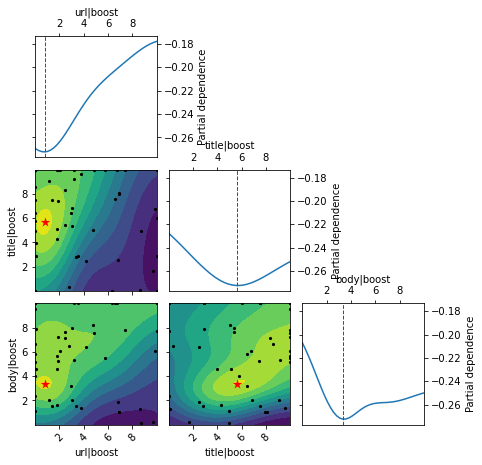

In [15]:
_ = plot_objective(metadata_boosts, sample_source='result')

## Experiment: all-in-one tuning

You might be wondering why bother doing the tuning step-wise, first searching through a few parameters, then moving onto the next set. When parameters are dependent on others, it might make sense to put all the parameters into a single, giant parameters space and try and optimize all at once. This is a more difficult optimization problem as the space is huge, but let's give it a shot and see what happens.

### Same number of iterations, same parameter space

First we'll use the same number of total) iterations and combined parameter space as in the above steps. This is more of an apples-to-apples comparison then. However since we can easily search over continuous parameter spaces using Bayesian optimization techniques, we'll make it slightly harder but more complete by allowing for any value in our range of `minimum_should_match` and `tie_breaker`, instead of providing just the limited, discrete values as we did above (that was more for a grid search example than anything else).

Note that in the following examples we supress progress output since we are using so many iterations.

In [16]:
%%time

_, _, final_params_boosts, metadata_boosts = optimize_query_mrr100(es, max_concurrent_searches, index, template_id,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 75,
        'num_initial_points': 60,
        'space': {
            'minimum_should_match': { 'low': 30, 'high': 70 },
            'tie_breaker': { 'low': 0.0, 'high': 1.0 },
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
        },
        'default': {
            'operator': 'OR',
        }
    }),
    verbose=False)

Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
Best score: 0.2691
Best params: {'minimum_should_match': 30, 'tie_breaker': 0.8786321805745646, 'url|boost': 0.0, 'title|boost': 5.22718312671884, 'body|boost': 10.0}
Final params: {'operator': 'OR', 'minimum_should_match': 30, 'tie_breaker': 0.8786321805745646, 'url|boost': 0.0, 'title|boost': 5.22718312671884, 'body|boost': 10.0}

CPU times: user 1min 25s, sys: 21.3 s, total: 1min 46s
Wall time: 26min 56s


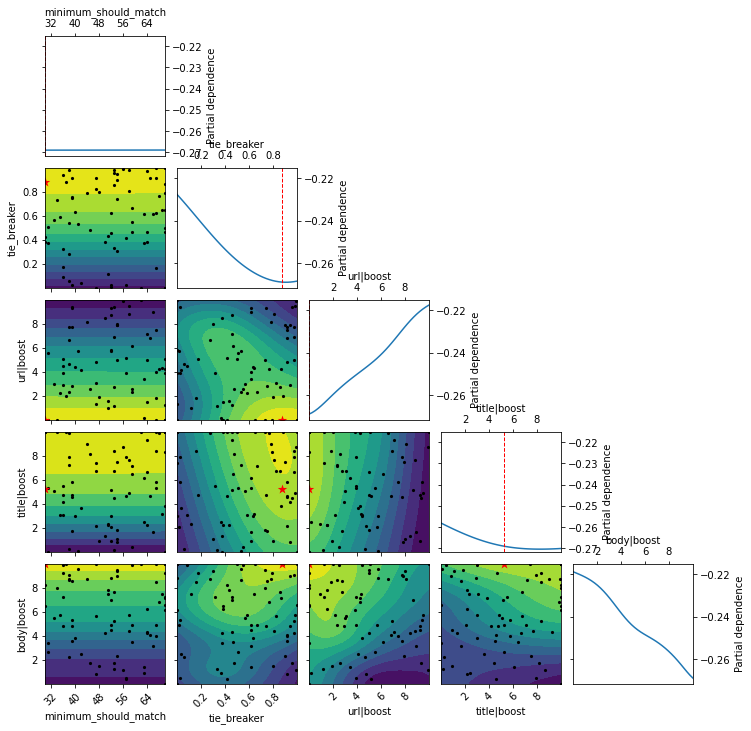

In [17]:
_ = plot_objective(metadata_boosts, sample_source='result')

In [18]:
%%time

_ = evaluate_mrr100_dev(es, max_concurrent_searches, index, template_id, params=final_params_boosts)

Evaluation with: MRR@100
Score: 0.2966
CPU times: user 2.7 s, sys: 829 ms, total: 3.53 s
Wall time: 2min 19s


Ok, so not a big difference to the step-wise method we used above, but maybe it was a bit simpler to just throw in a huge parameter space.

### More iterations, smaller parameter space using hints from prior grid search

Let's see if we can do even better by throwing more iterations into it, and by using a smaller search space for parameters that we already have a good range for `minimum_should_match` and `tie_breaker`, from the above grid search. This is kind of a hint and maybe not a fair comparison, but let's see if it makes any difference. We're not against using any prior knowledge to our advantage!

In [9]:
%%time

_, _, final_params_boosts, metadata_boosts = optimize_query_mrr100(es, max_concurrent_searches, index, template_id,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 100,
        'num_initial_points': 40,
        'space': {
            'minimum_should_match': { 'low': 30, 'high': 50 },  # 40 +/- 10
            'tie_breaker': { 'low': 0.1, 'high': 0.4 },  # 0.25 +/- 0.15
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
        },
        'default': {
            'operator': 'OR',
        }
    }),
    verbose=False)

Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
Best score: 0.2722
Best params: {'minimum_should_match': 50, 'tie_breaker': 0.30760048910016036, 'url|boost': 0.7862977659693517, 'title|boost': 10.0, 'body|boost': 6.132088006200265}
Final params: {'operator': 'OR', 'minimum_should_match': 50, 'tie_breaker': 0.30760048910016036, 'url|boost': 0.7862977659693517, 'title|boost': 10.0, 'body|boost': 6.132088006200265}

CPU times: user 4min 8s, sys: 45.1 s, total: 4min 53s
Wall time: 48min 17s


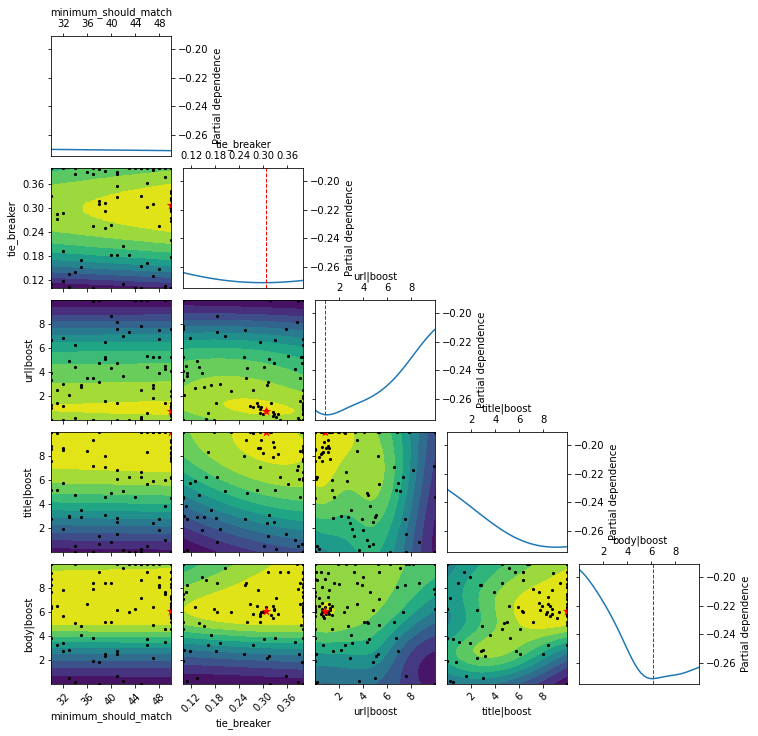

In [10]:
_ = plot_objective(metadata_boosts, sample_source='result')

In [11]:
%%time

_ = evaluate_mrr100_dev(es, max_concurrent_searches, index, template_id, params=final_params_boosts)

Evaluation with: MRR@100
Score: 0.3011
CPU times: user 2.51 s, sys: 738 ms, total: 3.25 s
Wall time: 1min 40s


Looks like we did about the same as the other methods in terms of MRR@100. In terms of simplicity though, this approach definitely wins as we can throw all the parameters in at once and not have to think too much about order and parameter dependencies.

### Random search

Something we haven't tried yet is a fully random search. When initializing Bayesian optimization, we're doing a uniform random sample from the parameter space, then using those points to seed the process. A common approach is actually to just do all your search iterations with random parameters. Let's use the same parameter space and try out a fully random search with a lot of iterations and see what happens.

In [12]:
%%time

_, _, final_params_boosts, metadata_boosts = optimize_query_mrr100(es, max_concurrent_searches, index, template_id,
    config_space=Config.parse({
        'method': 'random',
        'num_iterations': 75,
        'space': {
            'minimum_should_match': { 'low': 30, 'high': 70 },
            'tie_breaker': { 'low': 0.0, 'high': 1.0 },
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
        },
        'default': {
            'operator': 'OR',
        }
    }),
    verbose=False)

Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
Best score: 0.2708
Best params: {'minimum_should_match': 35, 'tie_breaker': 0.40232728150940966, 'url|boost': 0.2632415805622957, 'title|boost': 7.977800943265118, 'body|boost': 6.005064408641298}
Final params: {'operator': 'OR', 'minimum_should_match': 35, 'tie_breaker': 0.40232728150940966, 'url|boost': 0.2632415805622957, 'title|boost': 7.977800943265118, 'body|boost': 6.005064408641298}

CPU times: user 45.2 s, sys: 14.6 s, total: 59.8 s
Wall time: 32min 14s


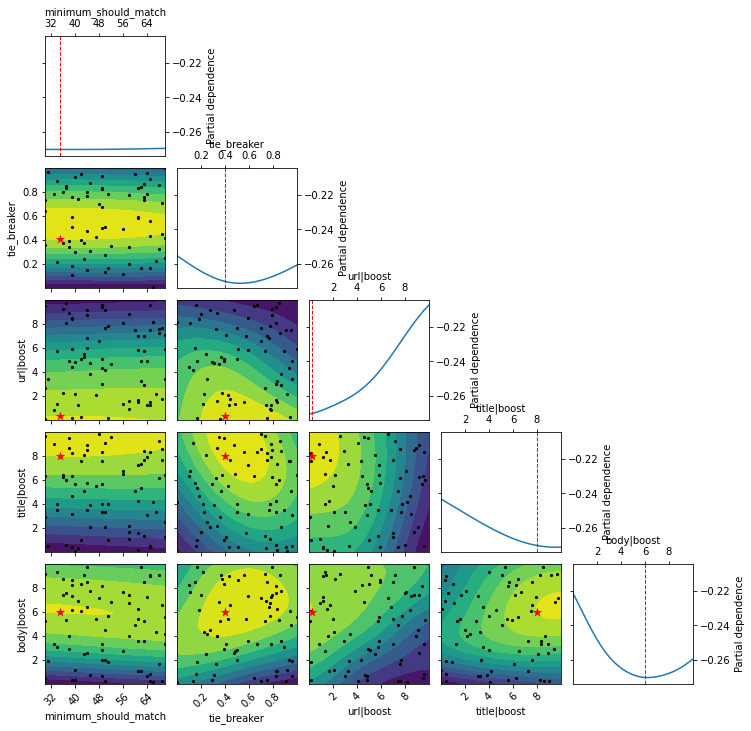

In [13]:
_ = plot_objective(metadata_boosts, sample_source='result')

In [14]:
%%time

_ = evaluate_mrr100_dev(es, max_concurrent_searches, index, template_id, params=final_params_boosts)

Evaluation with: MRR@100
Score: 0.2984
CPU times: user 2.55 s, sys: 751 ms, total: 3.3 s
Wall time: 2min 12s


So with the same number of iterations, we're not able to do any better than Bayesian optimization by just doing a random search. This is probably intuitive, but random search can sometimes be a good approach. Typically it does require more iterations than Bayesian optimization though. This is consistent with [previous findings](https://papers.nips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf) that show that manual tuning and random search are typically not as good at finding optimal hyperparameter than automatic sequential optimization like Bayesian optimization.

## Conclusion

In this notebook we covered grid searches for discrete parameter spaces and Bayesian optimization for large and continuous parameter spaces. We tried some experiments with very large parameter spaces as well. In the end, the methods did not differ that much in the final MRR@100 score on the development dataset. What we can conclude though is that there are sometimes relationships between parameters of a query and those need to be dealt with either by tuning stepwise, or trying to tune all at once. Furthermore, it can make sense to use step-wise optimization to get a better understanding of the meaning of parameters, the relationships between parameters, and often the performance tradeoffs. The latter is something we haven't gone into here, but for production workloads, it's important to understand not just the relevance metrics but the performance metrics as well. There are certainly times when you want to trade-off relevance for performance. It's also important to note that there are limitations to the size of the parameter space that Bayesian optimization will work well for. This is another reason to work step-wise and hold some parameters constant while tuning a new set of parameters either with a grid search or Bayesian optimization.

We hope that this notebook provides you with some ideas, some learnings, and a good foundation on which to tune your own search queries!